# 自己符号化器で通信システム(AWGN通信路)をモデリングする

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### グローバル変数の設定

In [2]:
M = 32
K = 100
num_hidden_units = 10 
sigma = 0.1

0.1

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    r = zeros(M, K)
    for j in 1:K
        r[rand(1:M),j] = 1
    end
    return r
end

mini_batch (generic function with 1 method)

### 全結合層の定義

In [4]:
enc1 = Dense(M, num_hidden_units) 
enc2 = Dense(num_hidden_units, 2) 
dec2 = Dense(2, num_hidden_units) 
dec1 = Dense(num_hidden_units, M) 

Dense(10, 32)

### 自己符号化器に基づく通信路モデル

In [5]:
function encoder(x, normalizer)
    x = relu.(enc1(x))
    x = enc2(x)
    x = normalizer(x)
    return x
end
function channel_model(x, normalizer)
    x = encoder(x, normalizer)
    y = x + sigma*randn(2, K)
    z = relu.(dec2(y))
    z = softmax(dec1(z))
    return z
end

channel_model (generic function with 1 method)

### 学習プロセス (ピーク電力制約)

In [6]:
opt = ADAM(1e-2) 
train_itr = 5000
loss(x,y) = norm(x-y)^2
peak_const(x) = x/sqrt(maximum(sum(x.^2,dims=1)))
ps = Flux.params(enc1,enc2,dec1,dec2)
for i in 1:train_itr
    x = mini_batch(K)
    gs = gradient(ps) do
        x̂ = channel_model(x, peak_const)
        loss(x, x̂)
    end
    Flux.Optimise.update!(opt, ps, gs)
    if i % 100 == 0
        x = mini_batch(K)
        x̂ = channel_model(x, peak_const)
        println(loss(x, x̂))
    end
end

77.21728894268831
56.11869022658642
34.615917920899456
29.325167219640996
29.003619396853775
24.98431015026817
25.06810059375667
19.328677180155477
23.366635851429916
21.399213693332072
19.21380213325646
25.645698804717032
29.975224369471153
22.491494408887682
28.835876389180026
24.216966643089613
15.002678220187882
24.441866156257117
19.966489904877285
21.51410342238177
16.166043990651897
13.434167922570712
18.69044950743528
16.725340514659408
25.357650145902515
19.0018893912449
21.58532275481938
16.43581206982952
19.698686347311504
16.633035026999192
16.96316205156684
27.666232617615595
20.565857019381678
15.914347626809894
22.721747036704006
17.06771100570563
22.995947419533277
16.43551196345261
15.360748216346648
17.70253143365273
16.647757255810784
16.182107981527896
19.945886409932005
22.88944295321676
15.03364009413377
16.638945849195135
16.579726220617353
22.573527049729055
17.464467608323314
12.872963730778325


### 学習された信号点配置の表示

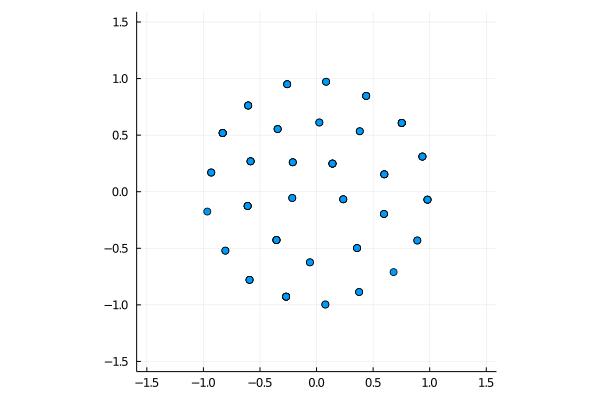

In [7]:
x = mini_batch(K)
x = encoder(x, peak_const)
p1 = Plots.scatter(x[1,:], x[2,:],legend=false, xlims=[-1.5,1.5], 
    ylims=[-1.5,1.5], aspect_ratio=1)

In [8]:
savefig("autoencoder-model.pdf")